<center><h1>Optical Flow</h1></center>
<hr/>

#### Imports

In [1]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ex1_utils import *

In [2]:
path = "collision/"

images = [cv2.imread(path + image_path, cv2.IMREAD_GRAYSCALE) for image_path in sorted(os.listdir(path))[1:]]

In [3]:
def show_flow1(u, v, image, title = 'Image', fig_name=None):
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    show_flow(u, v, ax, type="field", set_aspect=True)
    extent = (0, image.shape[1], -image.shape[0], 0)
    plt.imshow(image, 'gray', alpha=0.8, extent=extent)
    plt.title(title)
    plt.tight_layout()
    plt.axis('off')
    
    if fig_name:
        plt.savefig(fig_name, bbox_inches='tight')

### Lucas-Kanade

In [4]:
def lucas_kanade(im1: np.ndarray, im2: np.ndarray, N:int = 3, sigma:float = 1.0, normalize:bool = False, use_harris:bool = False, alpha:float = 0.04, thrs_rate:float = 0.001):
    
    assert im1.shape == im2.shape, 'Image sizes must be the same!'
    assert len(im1.shape) == 2, 'Images must be grayscale!'
    assert N % 2 != 0, 'N must be odd!'

    # Normalize the images
    I1 = im1 / 255.
    I2 = im2 / 255.
    
    # Smooth images using Gaussian bluring
    I1 = gausssmooth(I1, sigma)
    I2 = gausssmooth(I2, sigma)
    
    # Get horizontal and vertical derivative
    Ix1, Iy1 = gaussderiv(I1, sigma)
    Ix2, Iy2 = gaussderiv(I2, sigma)
    
    Ix, Iy = (Ix1 + Ix2) / 2., (Iy1 + Iy2) / 2.
    
    # Get temporal derivative and smooth it using Gaussian bluring
    It = gausssmooth(I2 - I1, sigma)
    
    # Calculate the optical flow using least-squares
    kernel = np.ones((N, N)) / N**2
    Ix2 = cv2.filter2D(Ix**2, -1, kernel)
    Iy2 = cv2.filter2D(Iy**2, -1, kernel)
    Ixy = cv2.filter2D(Ix * Iy, -1, kernel)
    Ixt = cv2.filter2D(Ix * It, -1, kernel)
    Iyt = cv2.filter2D(Iy * It, -1, kernel)
    
    D = Ix2 * Iy2 - Ixy**2
    D[D == 0] = 1e-8 # To avoid division by 0
    
    if use_harris:
        harris = D - alpha * (Ix2 + Iy2)**2
        harris = cv2.dilate(harris, None)
        threshold = thrs_rate*harris.max()
        mask = harris > threshold
        u = np.zeros_like(harris)
        v = np.zeros_like(harris)
        u[mask] = -(Iy2*Ixt - Ixy*Iyt)[mask] / D[mask]
        v[mask] = -(Ix2*Iyt - Ixy*Ixt)[mask] / D[mask]
    else:  
        u = -(Iy2*Ixt - Ixy*Iyt) / D
        v = -(Ix2*Iyt - Ixy*Ixt) / D

    
    # Normalize u and v using their magnitude
    if normalize:
        mag = np.sqrt(u ** 2 + v ** 2) + 1e-8
        u = np.where(mag > 0, u / mag, 0)
        v = np.where(mag > 0, v / mag, 0)
        
    return u, v, Ix, Iy, It

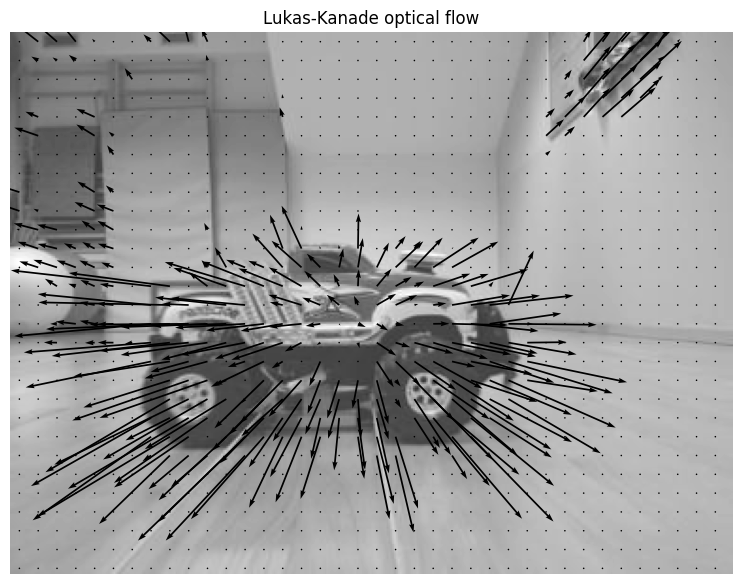

In [5]:
u, v, _, _, _ = lucas_kanade(images[154], images[155], N = 11, use_harris = True)
show_flow1(u, v, images[155], title = 'Lukas-Kanade optical flow')

### Lucas-Kanade Pyramidal

In [6]:
def gaussian_pyramid(im: np.ndarray, levels: int):
    pyramid = [im]
    for _ in range(levels):
        im = cv2.pyrDown(im)
        pyramid.append(im)
    return pyramid
        
    
def lucas_kanade_pyramid(im1: np.ndarray, im2: np.ndarray, N:int = 3, levels:int = 2, sigma:float = 1.0, normalize:bool = False):

    assert im1.shape == im2.shape, 'Image sizes must be the same!'
    assert len(im1.shape) == 2, 'Images must be grayscale!'
    assert N % 2 != 0, 'N must be odd!'

    pyramid1 = gaussian_pyramid(im1, levels)
    pyramid2 = gaussian_pyramid(im2, levels)

    # Calculate optical flow of the last level
    u, v, _, _, _ = lucas_kanade(pyramid1[-1], pyramid2[-1], N = N)

    for level in range(2, levels+2):
        # Upsample
        u, v = cv2.pyrUp(u), cv2.pyrUp(v)

        # Adjust size when the image size is odd, because pyrUp and pyrDown use scaling factor of 2
        u = cv2.resize(u, pyramid2[-level].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
        v = cv2.resize(v, pyramid2[-level].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

        # Wrap second image with the flow vectors
        h, w = u.shape[:2]
        map_u, map_v = np.meshgrid(np.arange(w), np.arange(h))
        map_u = (map_u + u).astype(np.float32)
        map_v = (map_v + v).astype(np.float32)

        im2_warp = cv2.remap(pyramid2[-level], map_u, map_v, cv2.INTER_LINEAR)

        # Clamp the pixel values of the warped image to the range [0, 255]
        # im02 = np.clip(im2_warp, 0, 255).astype(np.uint8)

        # Calculate optical flow of the current level
        u0, v0, _, _, _ = lucas_kanade(pyramid1[-level], im2_warp, N = N)

        u += u0
        v += v0
        
    return u, v

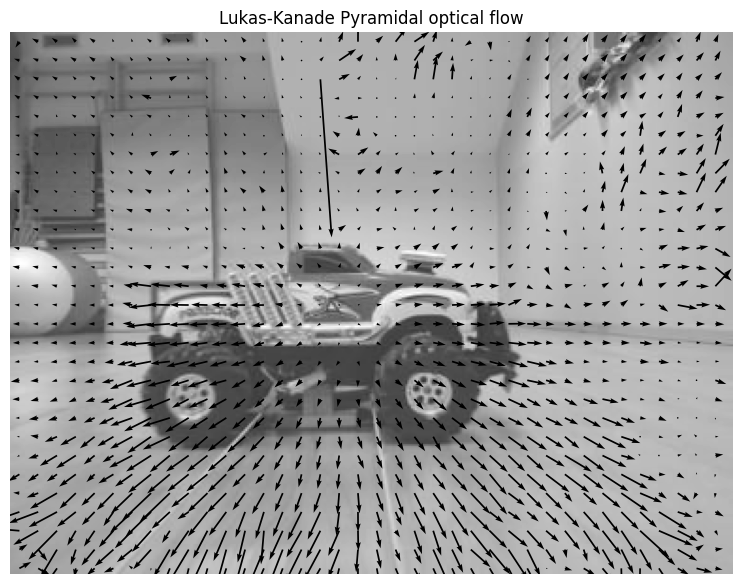

In [7]:
u, v = lucas_kanade_pyramid(images[154], images[155], N = 11, levels = 4)
show_flow1(u, v, images[155], title = 'Lukas-Kanade Pyramidal optical flow')

### Horn-Schuck

In [8]:
def horn_schunck(im1: np.ndarray, im2: np.ndarray, n_iters: int, lmbd: float, sigma:float = 1, normalize:bool = False):
    
    assert im1.shape == im2.shape, 'Image sizes must be the same!'
    assert len(im1.shape) == 2, 'Images must be grayscale!'

    # Normalize the images
    I1 = im1 / 255.
    I2 = im2 / 255.
    
    # Smooth images using Gaussian bluring
    I1 = gausssmooth(I1, sigma)
    I2 = gausssmooth(I2, sigma)
    
    # Get horizontal and vertical derivative
    Ix1, Iy1 = gaussderiv(I1, sigma)
    Ix2, Iy2 = gaussderiv(I2, sigma)
    
    Ix, Iy = (Ix1 + Ix2) / 2., (Iy1 + Iy2) / 2.
    
    # Get temporal derivative and smooth it using Gaussian bluring
    It = gausssmooth(I2 - I1, sigma)
    
    # Initialize u and v as zero matrices
    u = np.zeros_like(I1)
    v = np.zeros_like(I2)
    
    # Initialize D outside of loop as it is static
    D = lmbd + Ix**2 + Iy**2
    
    # Initialize Ld
    Ld = np.array([[0, 1/4., 0], [1/4., 0, 1/4.], [0, 1/4., 0]])
    
    # Iteratively update values
    for _ in range(n_iters):
        ua = cv2.filter2D(u, -1, Ld)
        va = cv2.filter2D(v, -1, Ld)
        
        P_D = (Ix * ua + Iy * va + It) / D
        
        u = ua - Ix * P_D
        v = va - Iy * P_D
        
    # Normalize u and v using their magnitude
    if normalize:
        mag = np.sqrt(u ** 2 + v ** 2) + 1e-8
        u = np.where(mag > 0, u / mag, 0)
        v = np.where(mag > 0, v / mag, 0)
        
    return u, v

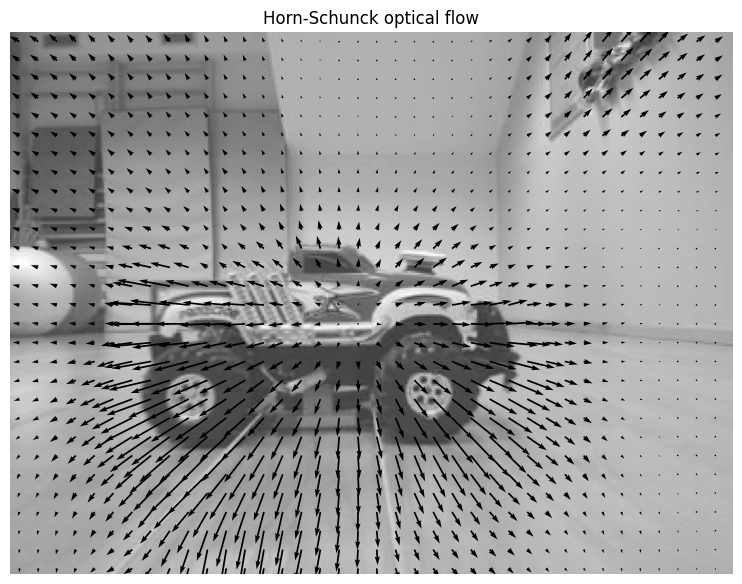

In [9]:
u, v = horn_schunck(images[154], images[155], 3000, 0.5)
show_flow1(u, v, images[155], title = 'Horn-Schunck optical flow')

### Horn-Shunck initialized with Lucas-Kanade

In [10]:
# Horn-Schunck initialized with Lukas-Kanade output

def horn_schunck2(im1: np.ndarray, im2: np.ndarray, n_iters: int, lmbd: float, sigma:float = 1, normalize:bool = False):
    
    assert im1.shape == im2.shape, 'Image sizes must be the same!'
    assert len(im1.shape) == 2, 'Images must be grayscale!'

    u, v, Ix, Iy, It = lucas_kanade(im1, im2, N = 11)
    
    # Initialize D outside of loop as it is static
    D = lmbd + Ix**2 + Iy**2
    
    # Initialize Ld
    Ld = np.array([[0, 1/4., 0], [1/4., 0, 1/4.], [0, 1/4., 0]])
    
    # Iteratively update values
    for _ in range(n_iters):
        ua = cv2.filter2D(u, -1, Ld)
        va = cv2.filter2D(v, -1, Ld)
        
        P_D = (Ix * ua + Iy * va + It) / D
        
        u = ua - Ix * P_D
        v = va - Iy * P_D
        
    # Normalize u and v using their magnitude
    if normalize:
        mag = np.sqrt(u ** 2 + v ** 2) + 1e-8
        u = np.where(mag > 0, u / mag, 0)
        v = np.where(mag > 0, v / mag, 0)
        
    return u, v

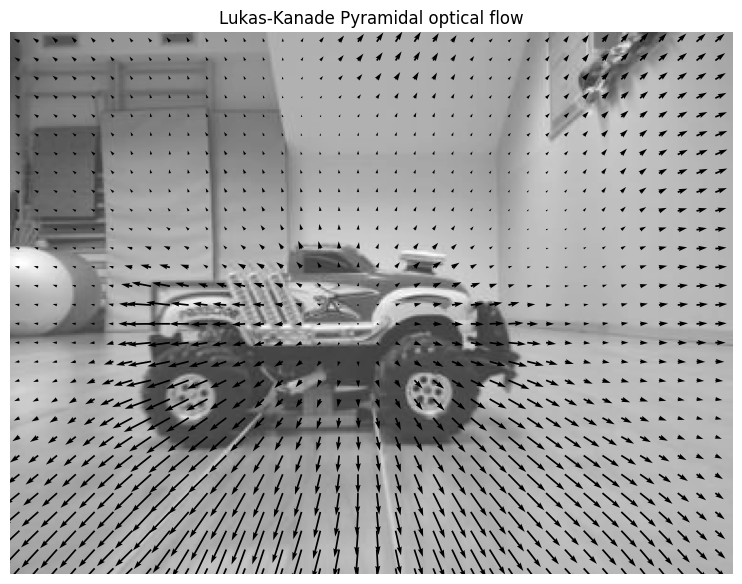

In [11]:
u, v = horn_schunck2(images[154], images[155], 1000, 0.5)
show_flow1(u, v, images[155], title = 'Lukas-Kanade Pyramidal optical flow')

### Comparing the methods

In [12]:
img1 = np.random.rand(200, 200).astype(np.float32)
img2 = img1.copy()
img2 = rotate_image(img2 , 1)

In [13]:
u1, v1, _, _, _ = lucas_kanade(img1, img2, N = 7)
u2, v2 = lucas_kanade_pyramid(img1, img2, N = 17, levels = 3)

u3, v3 = horn_schunck(img1, img2, 1000, 0.5)
u4, v4 = horn_schunck2(img1, img2, 1000, 0.5)

In [14]:
def display(axes, title):
    for axis in axes:
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    
    axes[0].set_ylabel(title)


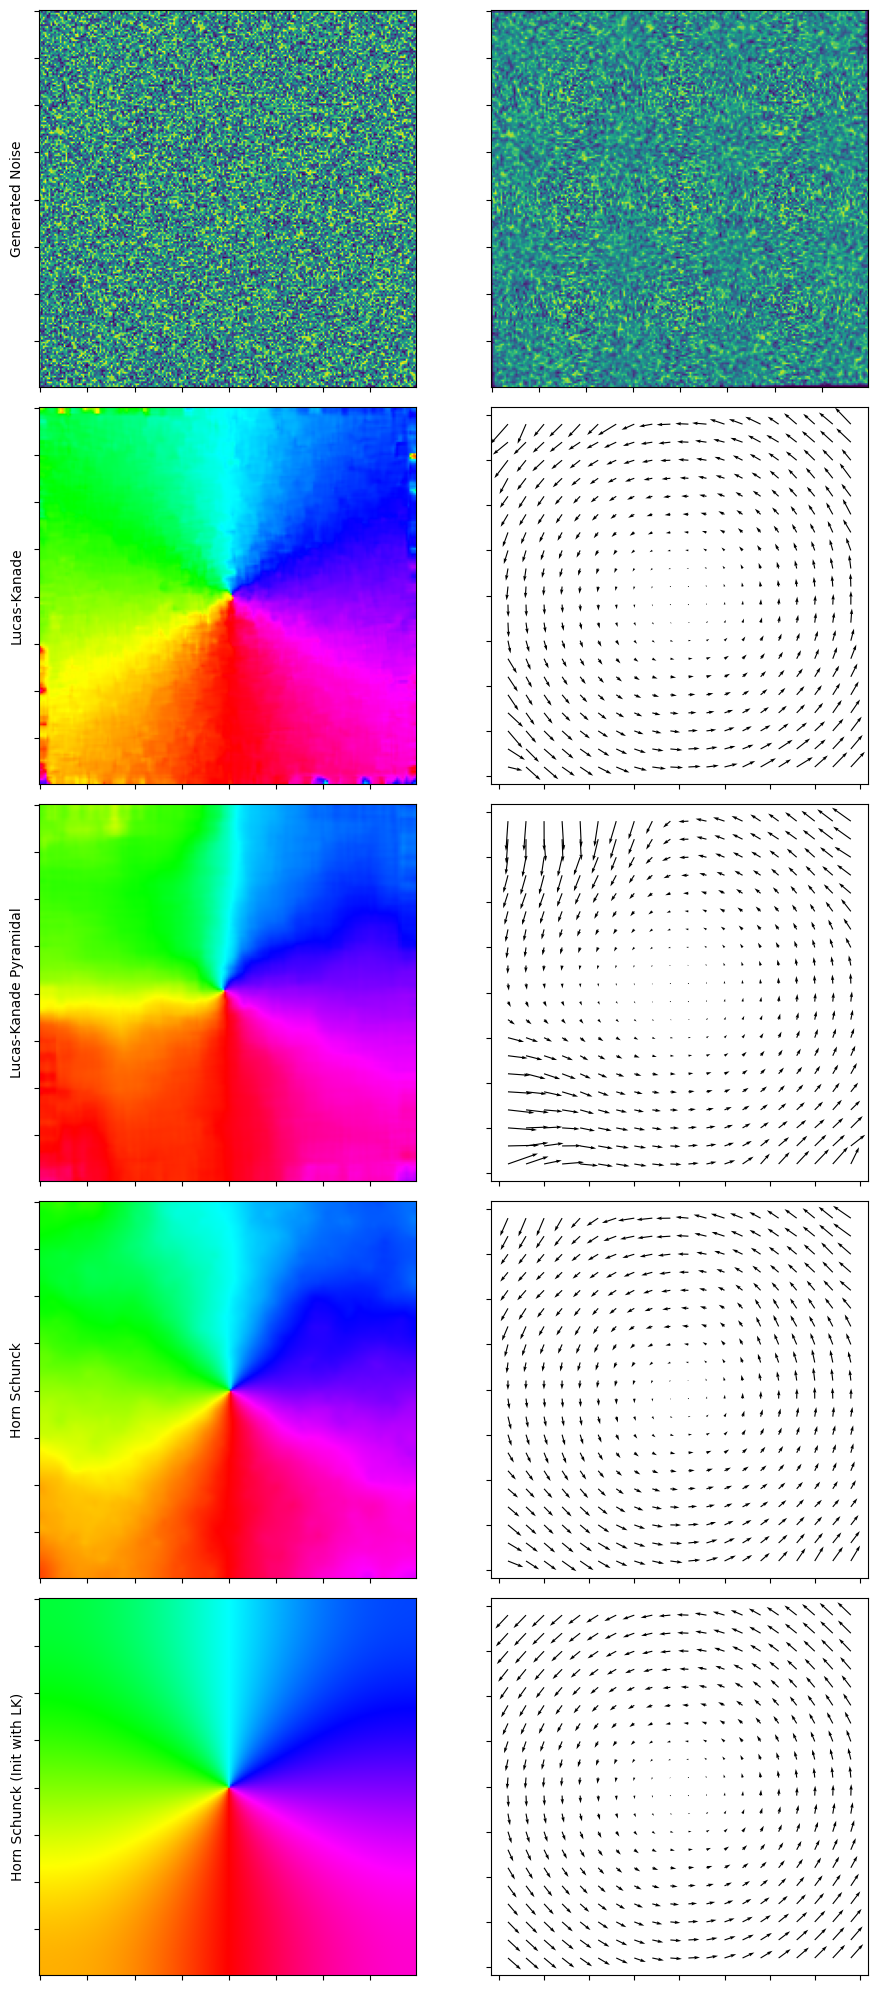

In [15]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

ax[0, 0].imshow(img1)
ax[0, 1].imshow(img2)
display(ax[0], "Generated Noise")

show_flow(u1, v1, ax[1, 0], type='angle')
show_flow(u1, v1, ax[1, 1], type='field', set_aspect=True)
display(ax[1], "Lucas-Kanade")

show_flow(u2, v2, ax[2, 0], type='angle')
show_flow(u2, v2, ax[2, 1], type='field', set_aspect=True)
display(ax[2], "Lucas-Kanade Pyramidal")

show_flow(u3, v3, ax[3, 0], type='angle')
show_flow(u3, v3, ax[3, 1], type='field', set_aspect=True)
display(ax[3], "Horn Schunck")

show_flow(u4, v4, ax[4, 0], type='angle')
show_flow(u4, v4, ax[4, 1], type='field', set_aspect=True)
display(ax[4], "Horn Schunck (Init with LK)")

plt.tight_layout()